In [ ]:
# -*- coding: utf-8 -*-
#
#  Copyright 2024 Technical University of Denmark
#  Authored by: Piotr Budzisz (DTU)
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  The dataset and files mentioned in the notebook belong to the CFU (Center for Fast Ultrasound Imaging) at DTU (Technical University of Denmark).
#
#  Note: The following code has been created for the purpose of a master's thesis by Piotr Budzisz titled
#  "Computational reduction of reconstruction artifacts in stitching-based biomedical computed tomography,"
#  written at the Technical University of Denmark. The file is based on and reuses parts and descriptions
#  from the Core Imaging Library notebooks created by :
#
#                   Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#
#  which can be found in the GitHub repository (https://github.com/TomographicImaging/CIL-Demos).
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 Technical University of Denmark
#

# PHASE 1 




In [1]:
# CIL core components needed
from cil.framework import ImageGeometry, AcquisitionGeometry, BlockDataContainer

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

# CIL example synthetic test image
from cil.utilities.dataexample import SHAPES

# CIL display tools
from cil.utilities.display import show2D, show1D, show_geometry

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# For shepp-logan test image in CIL tomophantom plugin
from cil.plugins import TomoPhantom as cilTomoPhantom

# Third-party imports
import numpy as np    
import matplotlib.pyplot as plt


from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.plugins.astra.processors import FBP
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter, Normaliser, Padder
import numpy as np
import scipy.io
import os


# apply circle mask 
from numpy import arange, meshgrid, isscalar, ndarray, pi, roll

import os
from cil.io import TIFFWriter
from skimage import color, io, measure, img_as_ubyte
import matplotlib.image as mpimg
import cv2
import h5py

In [2]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

In [3]:
# constants
# set the backend for FBP and the ProjectionOperator
device = 'gpu'
# set up default colour map for visualisation
cmap = "gray"
ca1 = -0.001
ca2 = 0.002

In [4]:
# circle mask
offset = 0

siz = 2048
if siz % 2:
    rang = arange(-siz / 2 + 1, siz / 2 + 1)
else:
    rang = arange(-siz / 2,siz / 2)
x,y = meshgrid(rang,rang)
z = x ** 2 + y ** 2
a = (z < (siz / 2 - abs(offset)) ** 2)

# phase 0

In [5]:
from cil.recon import FBP
# load slice
datapath = "/dtu/cfu/data/userdata18/s220464/storage/KIDNEY_DATA"
filename = "slice3_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)
# create and show acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

ig = ag.get_ImageGeometry()

#show_geometry(ag)

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)

data = AcquisitionData(projs, geometry=ag, deep_copy=False)


data.reorder('astra')
ig = ag.get_ImageGeometry()

('horizontal', 'angle')


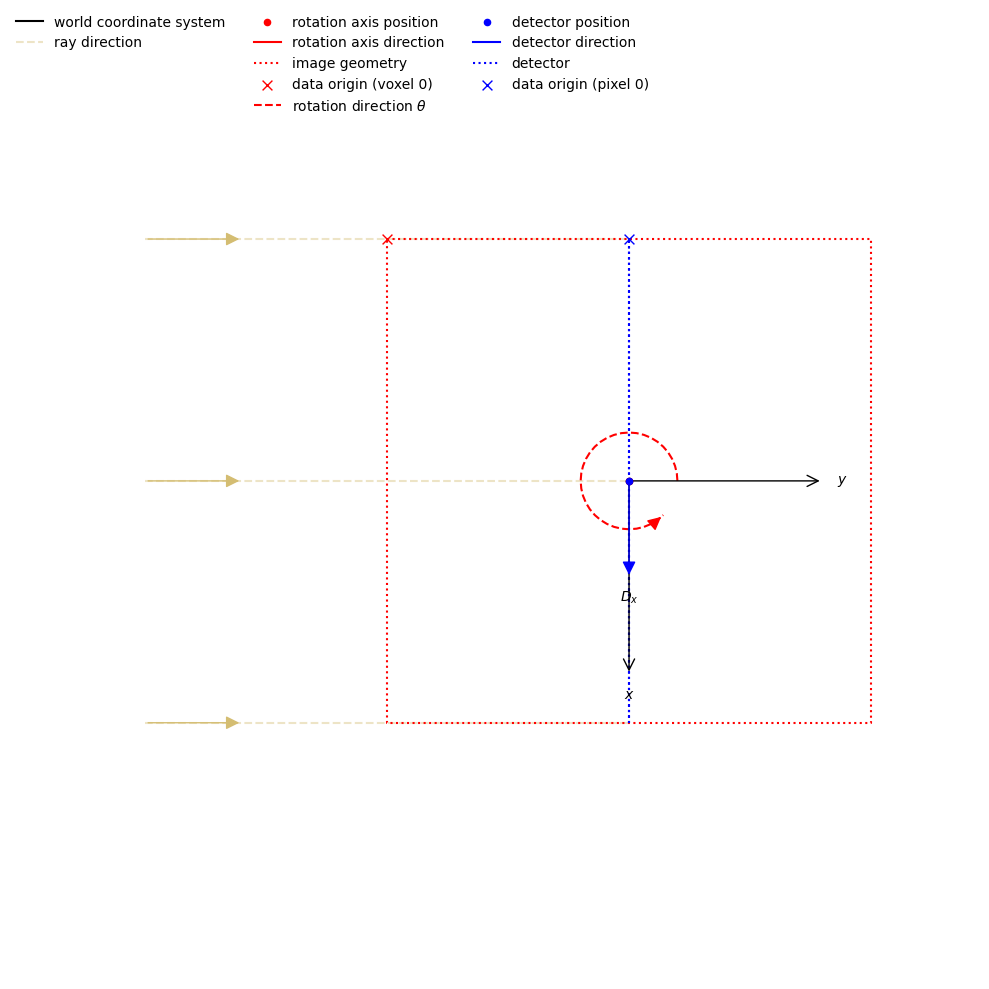

Saved image as /dtu/cfu/home/s220464/Code/Phase1/fbp_geom.png


<Figure size 640x480 with 0 Axes>

In [6]:
show_geometry(ag, ig).save('fbp_geom.png')

In [7]:
padsize = 256
data_pad_256 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_256 = FBP(data_pad_256, ig, backend='astra').run()
recon_fbp_256 = rec_256 * a

padsize = 512
data_pad_512 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_512 = FBP(data_pad_512, ig, backend='astra').run()
recon_fbp_512 = rec_512 * a

padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_1024 = FBP(data_pad_1024, ig, backend='astra').run()
recon_fbp_1024 = rec_1024 * a

padsize = 2048
data_pad_2048 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_2048 = FBP(data_pad_2048, ig, backend='astra').run()
recon_fbp_2048 = rec_2048 * a

padsize = 4096
data_pad_4096 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_4096 = FBP(data_pad_4096, ig, backend='astra').run()
recon_fbp_4096 = rec_4096 * a

padsize = 8192
data_pad_8192 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_8192 = FBP(data_pad_8192, ig, backend='astra').run()
recon_fbp_8192 = rec_8192 * a

FBP recon

Input Data:
	angle: 1800
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 3072

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 4096

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 6144

Reconstruction Volume:
	horizontal_y: 2048
	horizon

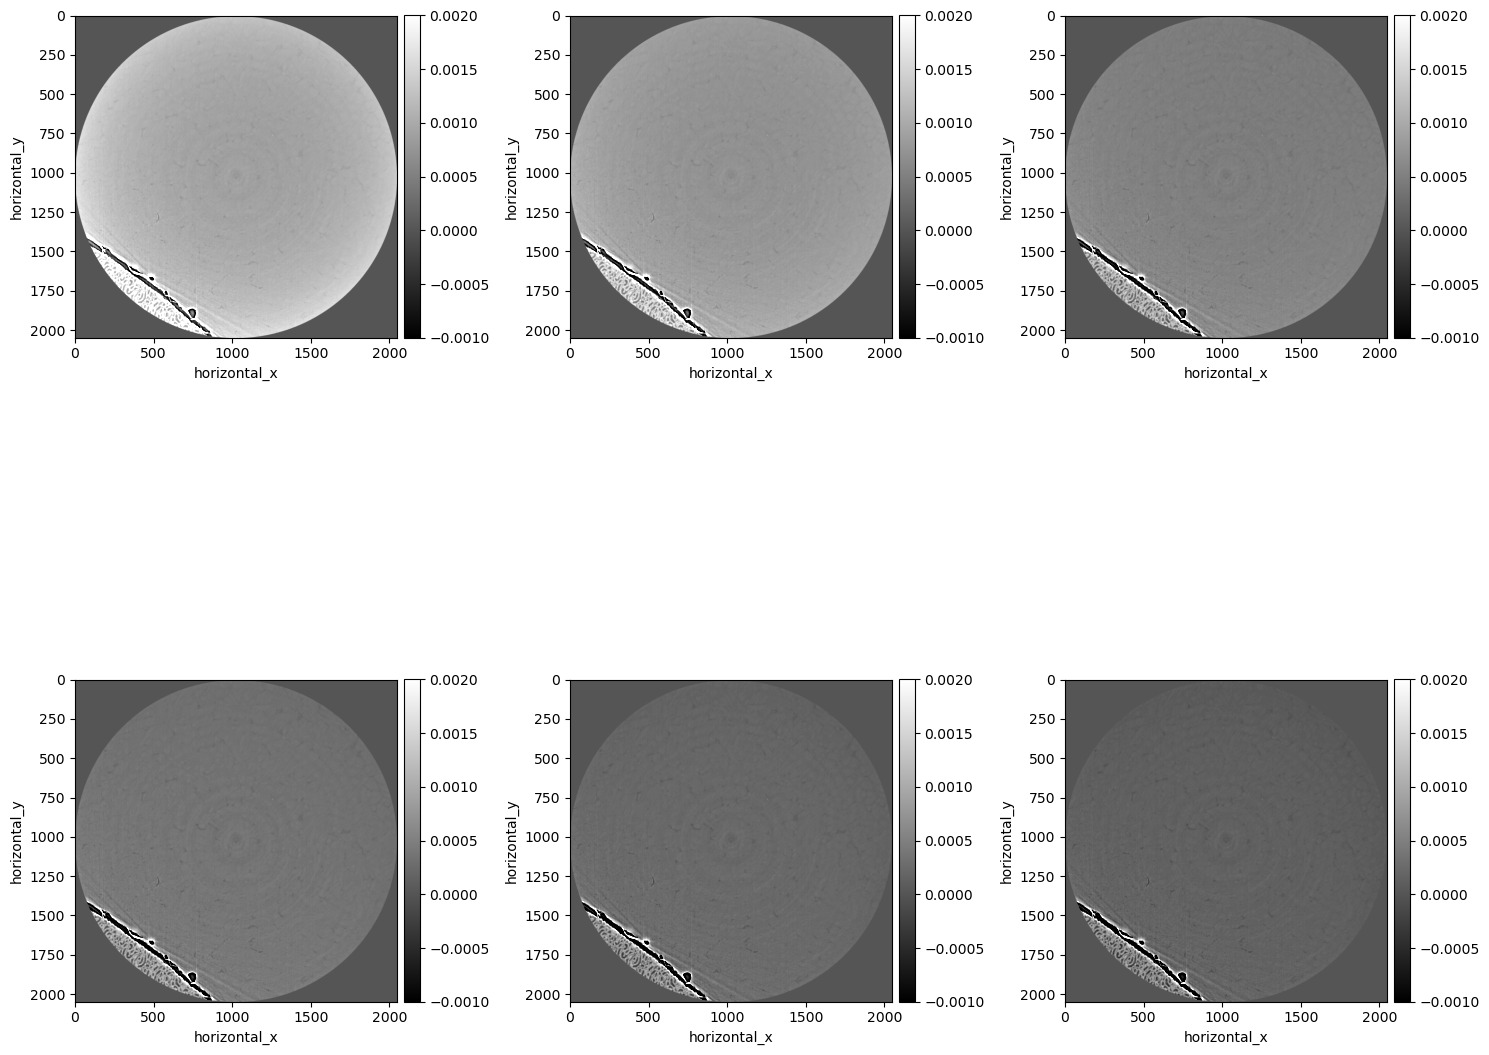

In [8]:
show2D([recon_fbp_256, recon_fbp_512, recon_fbp_1024, recon_fbp_2048, recon_fbp_4096, recon_fbp_8192], cmap=cmap, fix_range = (ca1, ca2), num_cols=3, size=(15,15), origin='upper-left')

Saved image as /dtu/cfu/data/userdata18/s220464/storage/PHASE_1/line_profile_empty.png


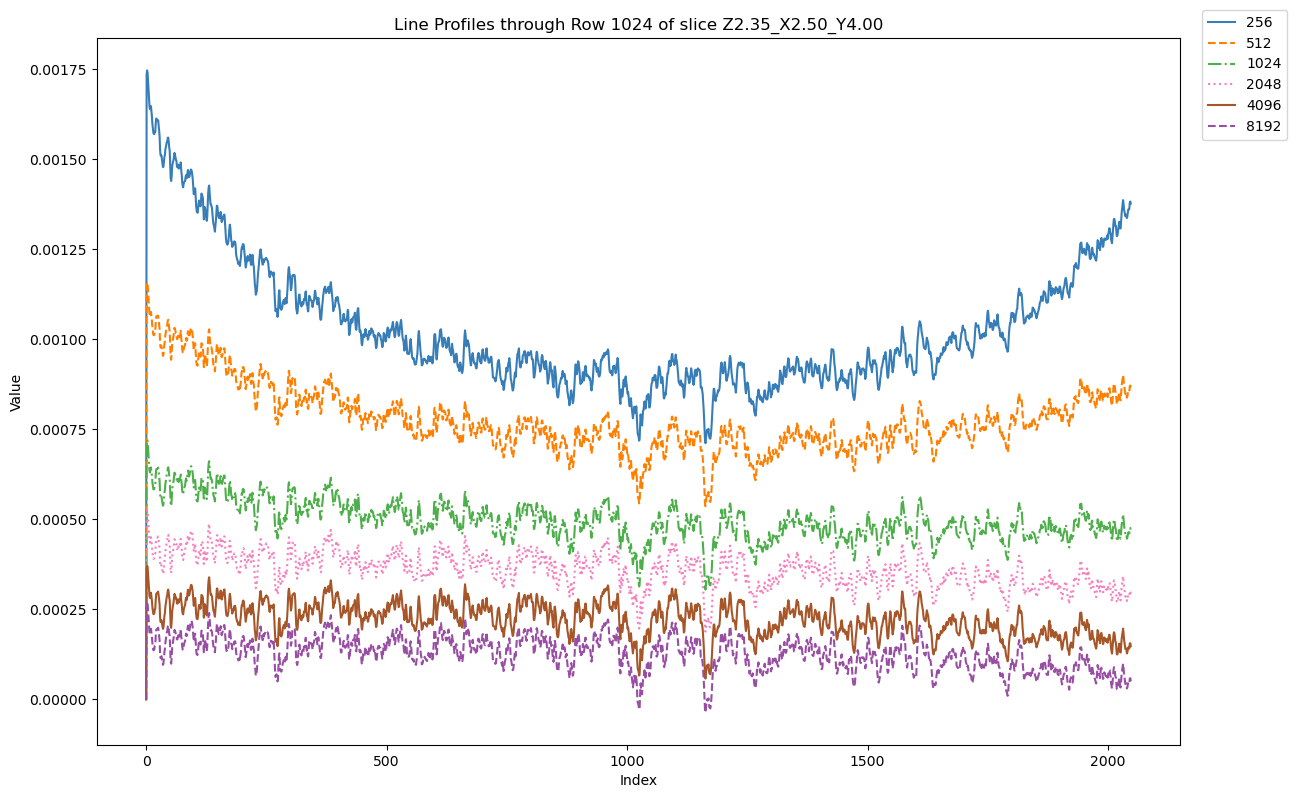

In [9]:
linenumy = 1024

# Specify the save path
path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/'
filename = 'line_profile_empty.png'
full_path = path + filename

# Save the figure
#fig.savefig(full_path, dpi=300, bbox_inches='tight')

show1D([recon_fbp_256, recon_fbp_512, recon_fbp_1024, recon_fbp_2048, recon_fbp_4096, recon_fbp_8192],
       slice_list=[('horizontal_y',linenumy)],
       label=['256', '512', '1024', '2048', '4096', '8192'],
       title='Line Profiles through Row 1024 of slice Z2.35_X2.50_Y4.00',

      #line_colours=['blue','orange'],
      #line_styles=['dotted','dashed'],
      size=(12,8)).save(full_path)

In [10]:
import os
from cil.io import TIFFWriter
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/fbp_slice3/'

# Dictionary mapping numbers to data variables
data_map = {
    256: recon_fbp_256,
    512: recon_fbp_512,
    1024: recon_fbp_1024,
    2048: recon_fbp_2048,
    4096: recon_fbp_4096,
    8192: recon_fbp_8192,
}


# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'recon_fbp_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()

# show sinograms

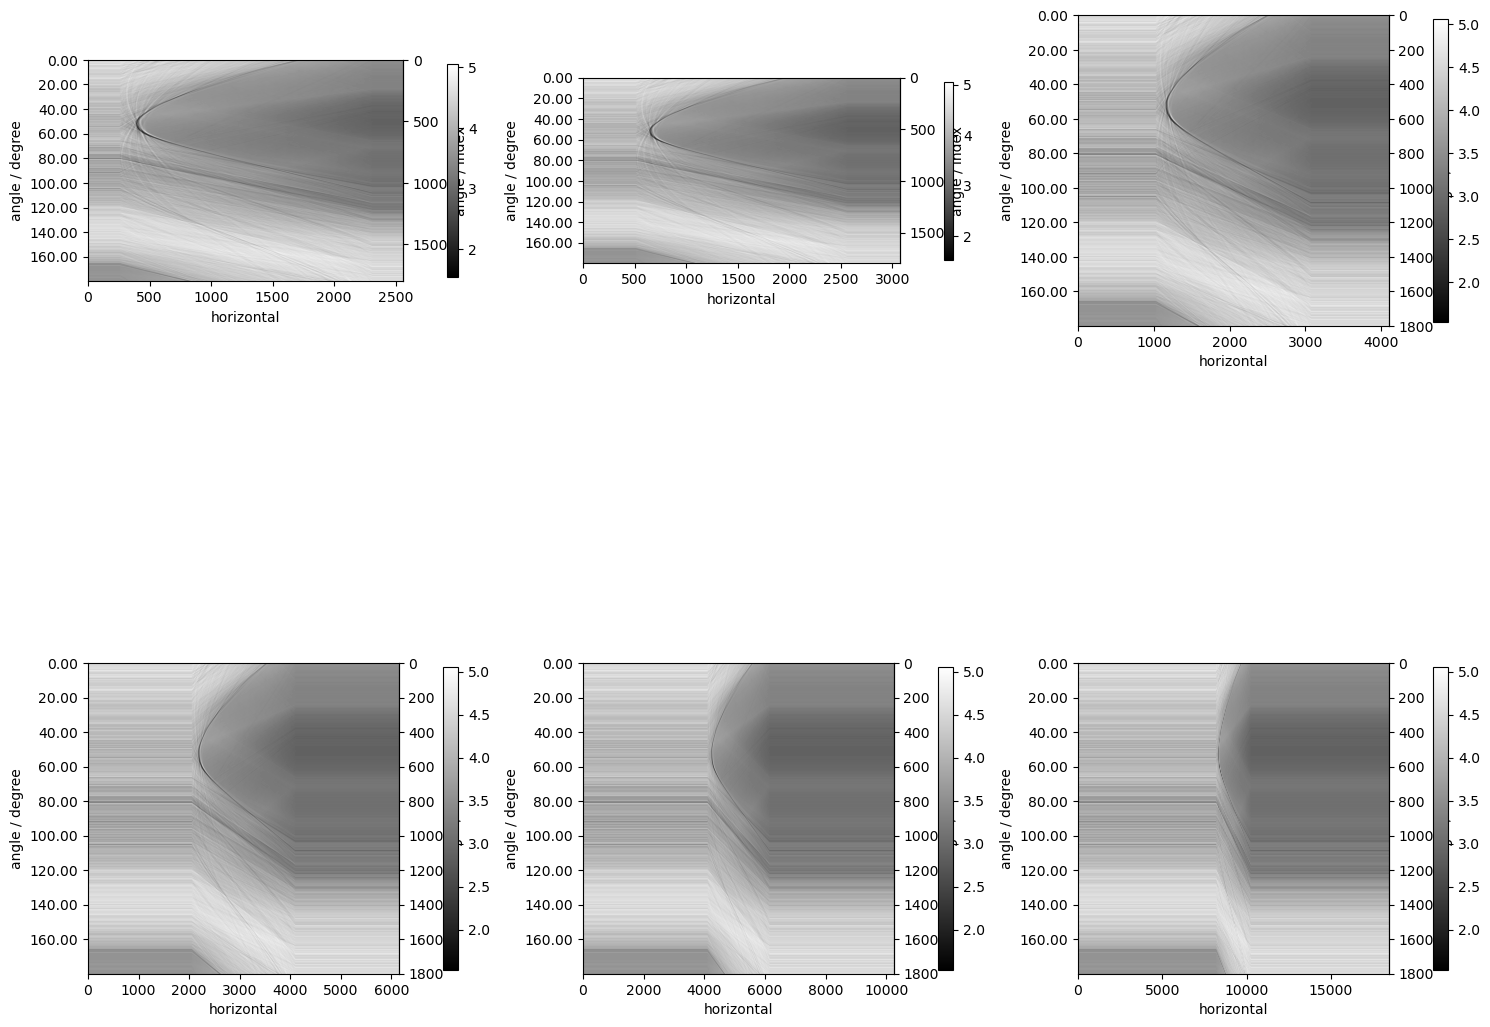

Saved image as /dtu/cfu/home/s220464/Code/Phase1/sino_pad.png


<Figure size 640x480 with 0 Axes>

In [11]:
show2D([data_pad_256, data_pad_512, data_pad_1024, data_pad_2048, data_pad_4096, data_pad_8192], cmap=cmap, num_cols=3, size=(15,15), origin='upper-left').save('sino_pad.png')

In [12]:
import os
from cil.io import TIFFWriter
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/fbp_slice3_padding/'

# Dictionary mapping numbers to data variables
data_map = {
    256: data_pad_256,
    512: data_pad_512,
    1024: data_pad_1024,
    2048: data_pad_2048,
    4096: data_pad_4096,
    8192: data_pad_8192,
}


# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'data_pad_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()

# save a single sinogram

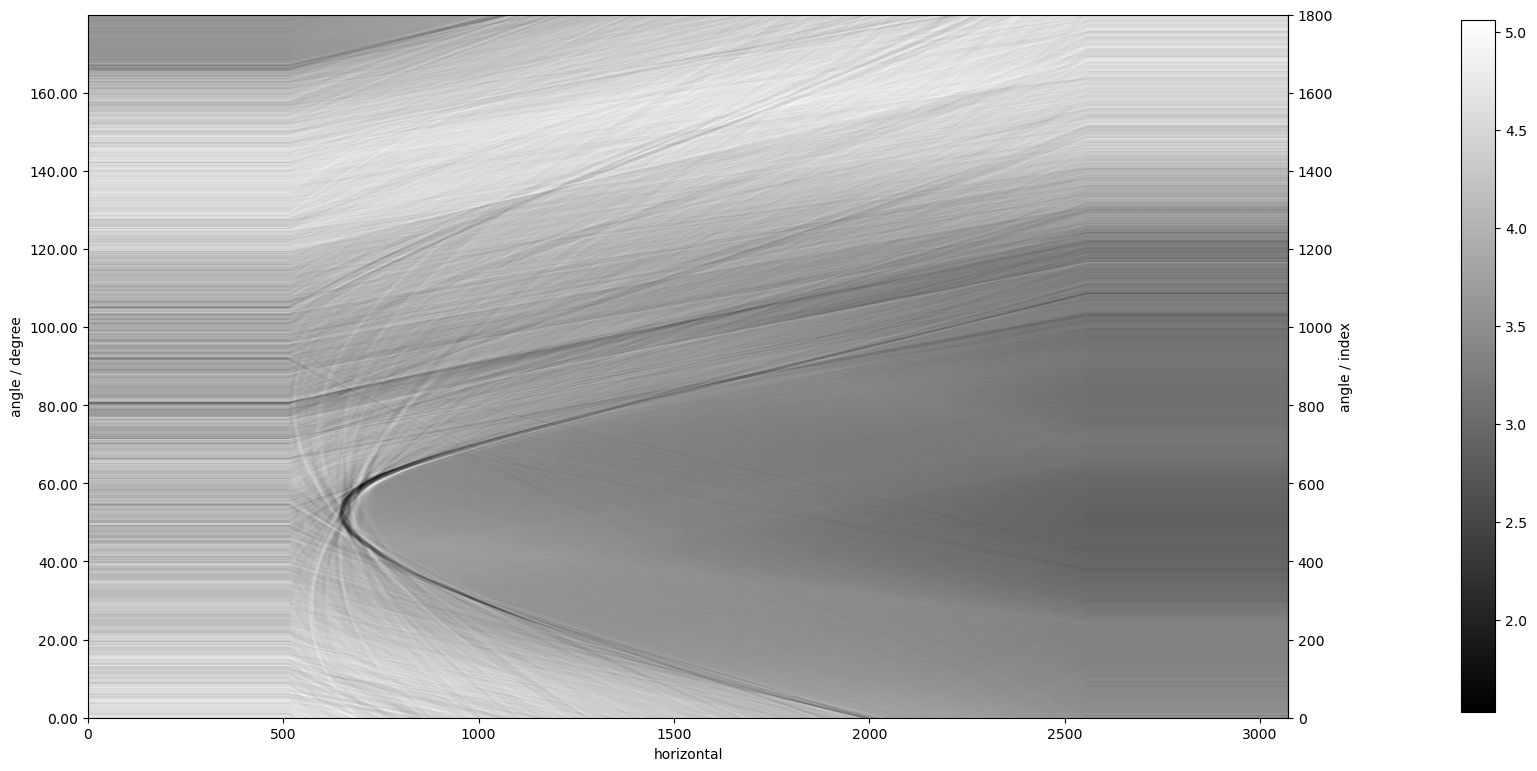

Saved image as /dtu/cfu/home/s220464/Code/Phase1/sino512.png


<Figure size 640x480 with 0 Axes>

In [13]:
show2D(data_pad_512).save('sino512.png')

# import slice

In [5]:
# load slice
datapath = "/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/"
filename = "slice5_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)

ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)
data = AcquisitionData(projs, geometry=ag, deep_copy=False)

data.reorder('astra')
ig = ag.get_ImageGeometry()

A = ProjectionOperator(ig, ag, device)


('horizontal', 'angle')


# vary padsize

In [6]:
padsize = 512
data_pad_512 = Padder.edge(pad_width={'horizontal': padsize})(data)
ag_512 = data_pad_512.geometry
ig_512 = ag_512.get_ImageGeometry()
A_512 = ProjectionOperator(ig_512, ag_512, device)
data_pad_512.shape

(1800, 3072)

In [7]:
padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)
ag_1024 = data_pad_1024.geometry
ig_1024 = ag_1024.get_ImageGeometry()
A_1024 = ProjectionOperator(ig_1024, ag_1024, device)
data_pad_1024.shape

(1800, 4096)

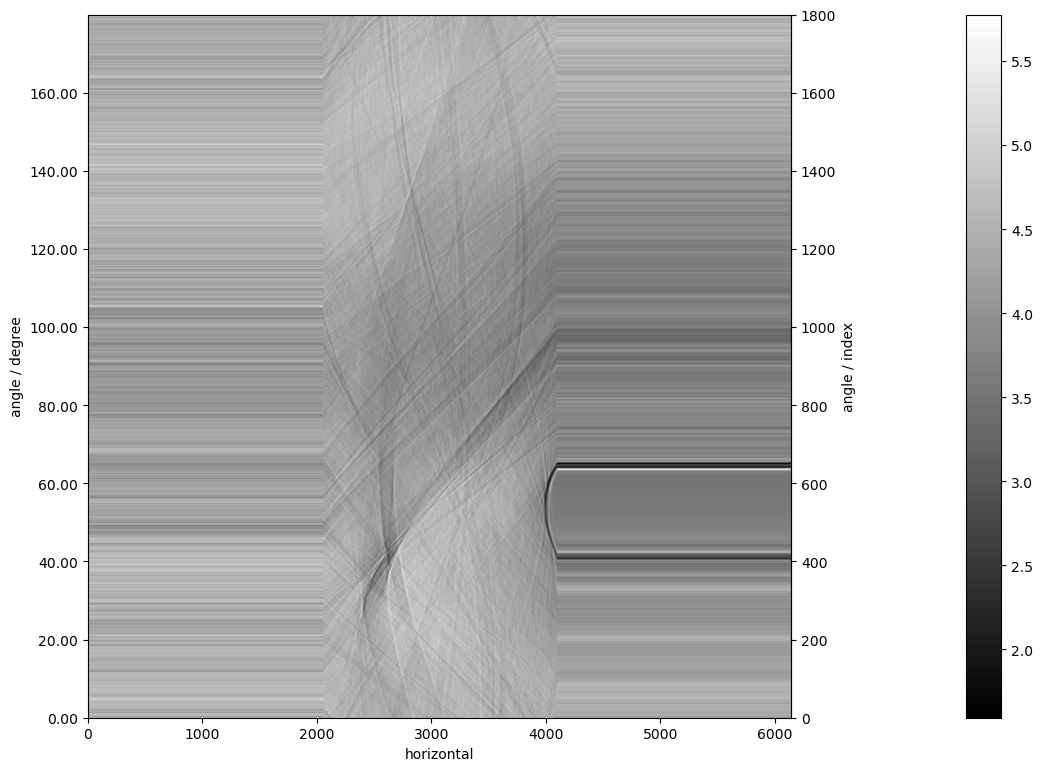

In [8]:
padsize = 2048
data_pad_2048 = Padder.edge(pad_width={'horizontal': padsize})(data)
ag_2048 = data_pad_2048.geometry
ig_2048 = ag_2048.get_ImageGeometry()
A_2048 = ProjectionOperator(ig_2048, ag_2048, device)
data_pad_2048.shape
show2D(data_pad_2048)

In [9]:
padsize = 4096
data_pad_4096 = Padder.edge(pad_width={'horizontal': padsize})(data)
ag_4096 = data_pad_4096.geometry
ig_4096 = ag_4096.get_ImageGeometry()
A_4096 = ProjectionOperator(ig_4096, ag_4096, device)

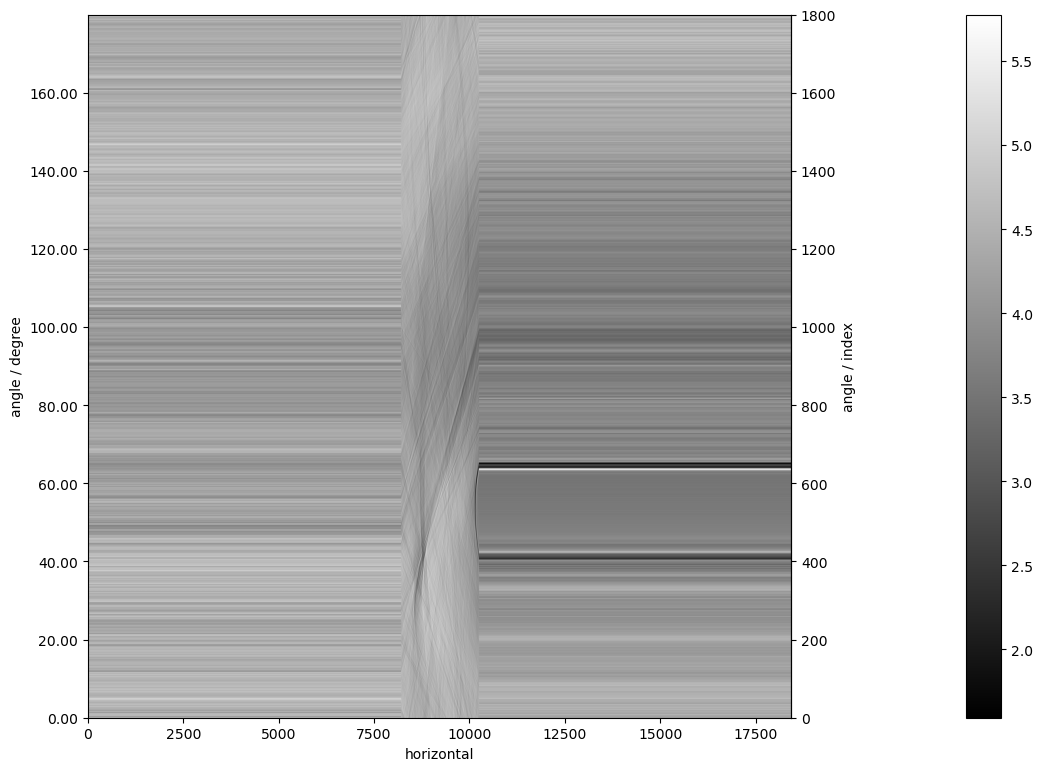

In [10]:
padsize = 8192
data_pad_8192 = Padder.edge(pad_width={'horizontal': padsize})(data)
ag_8192 = data_pad_8192.geometry
ig_8192 = ag_8192.get_ImageGeometry()
A_8192 = ProjectionOperator(ig_8192, ag_8192, device)
show2D(data_pad_8192)

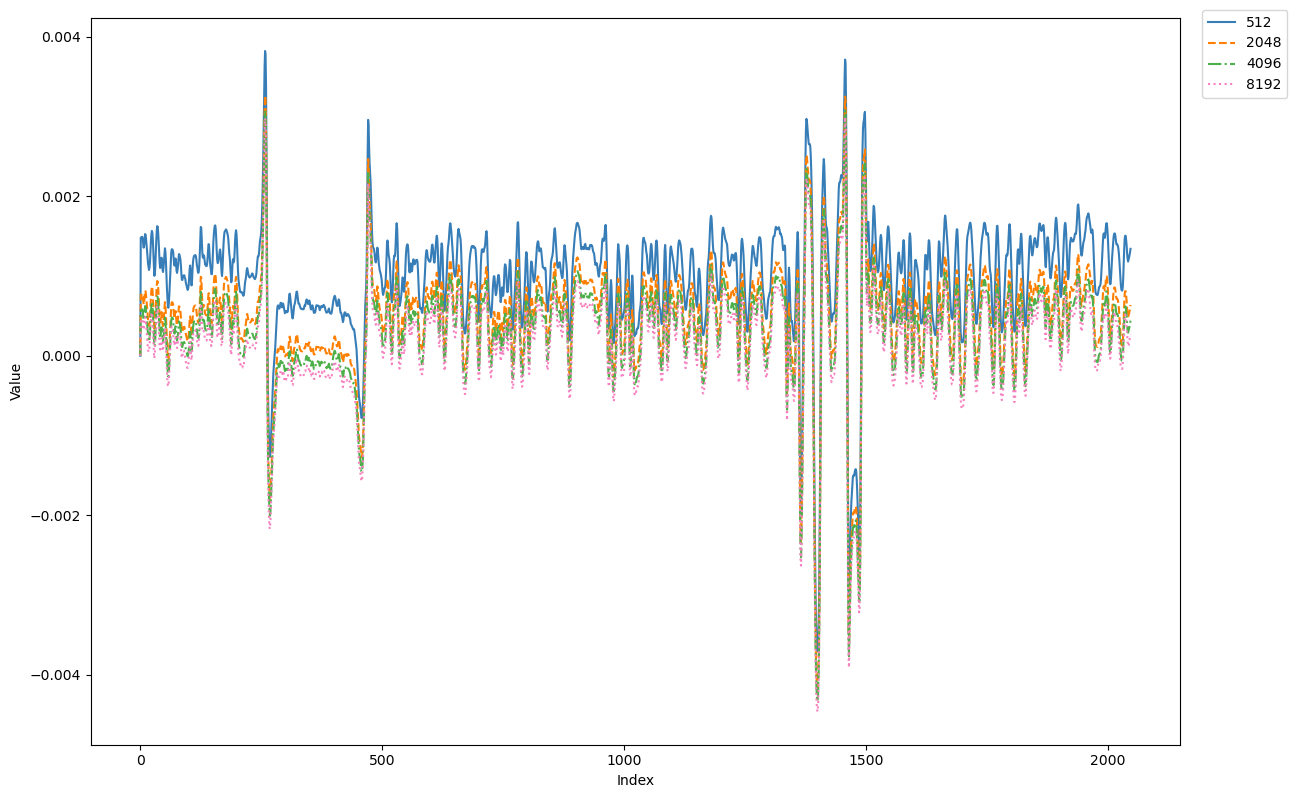

In [35]:
linenumy = 1024

show1D([recon_fbp_512, recon_fbp_2048, recon_fbp_4096, recon_fbp_8192],
       slice_list=[('horizontal_y',linenumy)],
       label=['512', '2048', '4096', '8192'],
      #line_colours=['blue','orange'],
      #line_styles=['dotted','dashed'],
      size=(12,8))

#  different setting

In [18]:
from cil.recon import FBP
# load slice
datapath = "/dtu/cfu/data/userdata18/s220464/storage/KIDNEY_DATA"
filename = "slice1_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)
# create and show acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

#show_geometry(ag)

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)

data = AcquisitionData(projs, geometry=ag, deep_copy=False)


data.reorder('astra')
ig = ag.get_ImageGeometry()

('horizontal', 'angle')


In [19]:
padsize = 256
data_pad_256 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_256 = FBP(data_pad_256, ig, backend='astra').run()
recon_fbp_256 = rec_256 * a

padsize = 512
data_pad_512 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_512 = FBP(data_pad_512, ig, backend='astra').run()
recon_fbp_512 = rec_512 * a

padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_1024 = FBP(data_pad_1024, ig, backend='astra').run()
recon_fbp_1024 = rec_1024 * a

padsize = 2048
data_pad_2048 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_2048 = FBP(data_pad_2048, ig, backend='astra').run()
recon_fbp_2048 = rec_2048 * a

padsize = 4096
data_pad_4096 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_4096 = FBP(data_pad_4096, ig, backend='astra').run()
recon_fbp_4096 = rec_4096 * a

padsize = 8192
data_pad_8192 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_8192 = FBP(data_pad_8192, ig, backend='astra').run()
recon_fbp_8192 = rec_8192 * a

FBP recon

Input Data:
	angle: 1800
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 3072

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 4096

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 6144

Reconstruction Volume:
	horizontal_y: 2048
	horizon

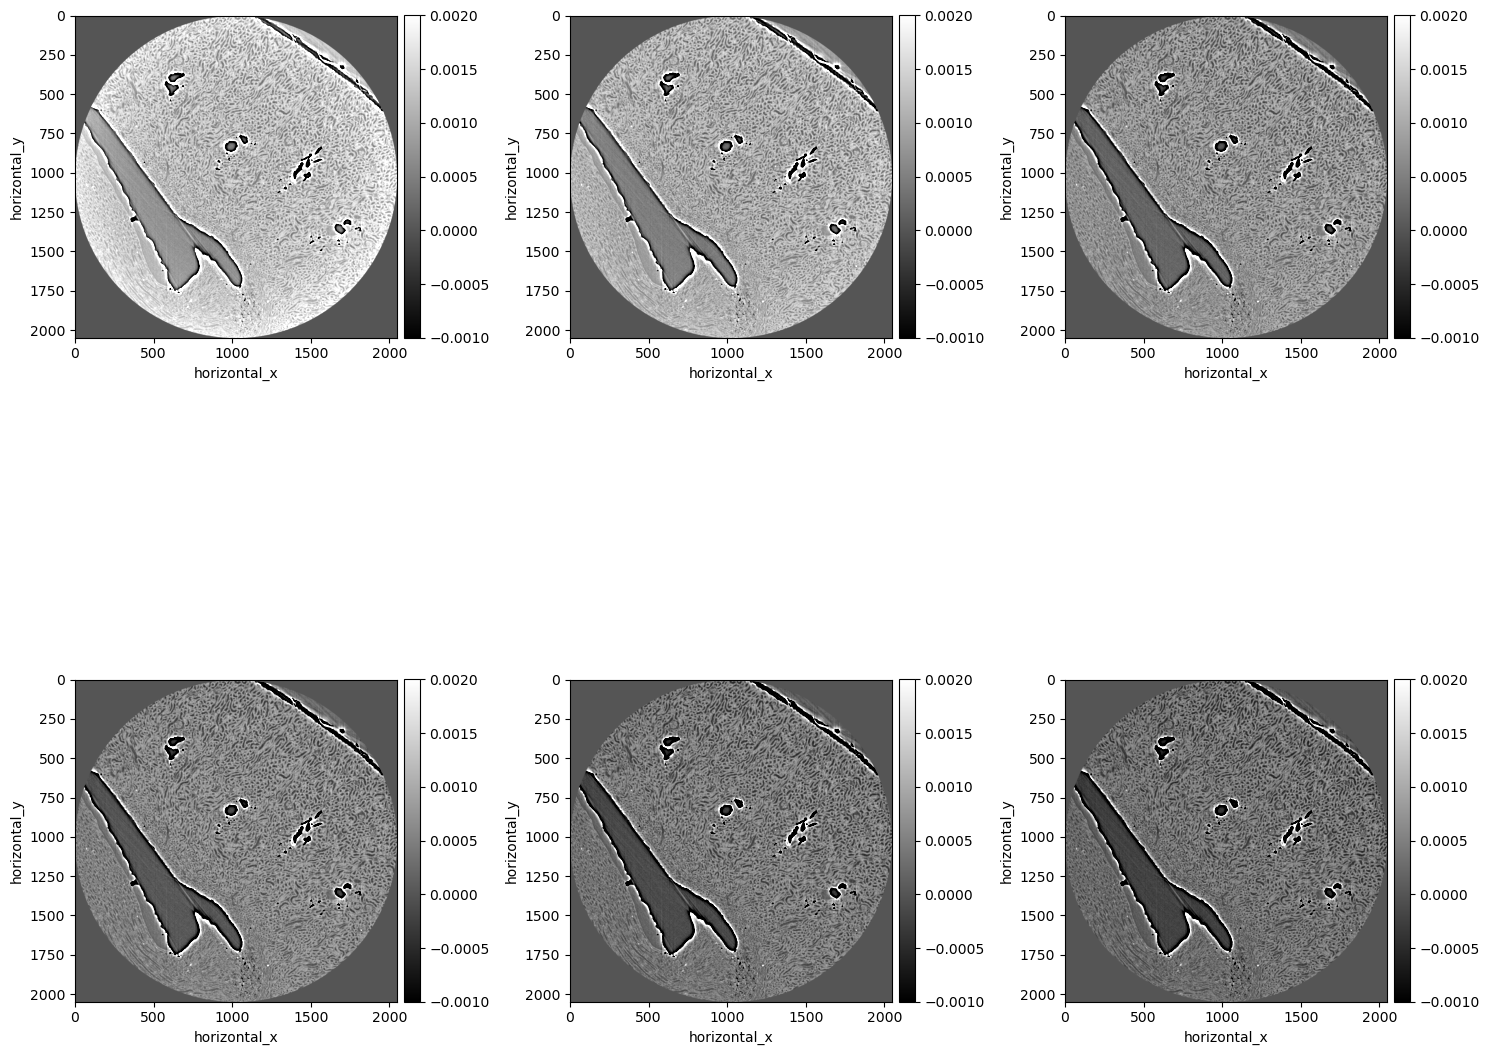

In [20]:
show2D([recon_fbp_256, recon_fbp_512, recon_fbp_1024, recon_fbp_2048, recon_fbp_4096, recon_fbp_8192], cmap=cmap, fix_range = (ca1, ca2), num_cols=3, size=(15,15), origin='upper-left')

In [21]:
import os
from cil.io import TIFFWriter
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/fbp_slice1/'

# Dictionary mapping numbers to data variables
data_map = {
    256: recon_fbp_256,
    512: recon_fbp_512,
    1024: recon_fbp_1024,
    2048: recon_fbp_2048,
    4096: recon_fbp_4096,
    8192: recon_fbp_8192,
}


# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'recon_fbp_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()

# lets create the files for stitching purposes

In [45]:
# load slice
from cil.recon import FBP
datapath = "/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/kidney_data"
filename = "slice3_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)


# create and show acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

#show_geometry(ag)

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)

data = AcquisitionData(projs, geometry=ag, deep_copy=False)


data.reorder('astra')
ig = ag.get_ImageGeometry()

('horizontal', 'angle')


In [46]:
padsize = 512
data_pad_512 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_512 = FBP(data_pad_512, ig, backend='astra').run()
recon_fbp_512 = rec_512 * a

padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_1024 = FBP(data_pad_1024, ig, backend='astra').run()
recon_fbp_1024 = rec_1024 * a

padsize = 2048
data_pad_2048 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_2048 = FBP(data_pad_2048, ig, backend='astra').run()
recon_fbp_2048 = rec_2048 * a

padsize = 4096
data_pad_4096 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_4096 = FBP(data_pad_4096, ig, backend='astra').run()
recon_fbp_4096 = rec_4096 * a

padsize = 8192
data_pad_8192 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_8192 = FBP(data_pad_8192, ig, backend='astra').run()
recon_fbp_8192 = rec_8192 * a

FBP recon

Input Data:
	angle: 1800
	horizontal: 3072

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 4096

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 6144

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 14
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 10240

Reconstruction Volume:
	horizontal_y: 2048
	horizo

In [ ]:
show2D([recon_fbp_512, recon_fbp_1024, recon_fbp_2048, recon_fbp_4096, recon_fbp_8192], cmap=cmap, fix_range = (ca1, ca2), num_cols=5, size=(15,15), origin='upper-left')

In [47]:
import os
from cil.io import TIFFWriter
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/fbp_slice3/'

# Dictionary mapping numbers to data variables
data_map = {
    512: recon_fbp_512,
    1024: recon_fbp_1024,
    2048: recon_fbp_2048,
    4096: recon_fbp_4096,
    8192: recon_fbp_8192,
}


# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'recon_fbp_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()

## slice 2


In [110]:
# load slice
from cil.recon import FBP
datapath = "/dtu/cfu/data/userdata18/s220464/storage/KIDNEY_DATA"
filename = "slice4_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)


# create and show acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

#show_geometry(ag)

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)

data = AcquisitionData(projs, geometry=ag, deep_copy=False)


data.reorder('astra')
ig = ag.get_ImageGeometry()

('horizontal', 'angle')


In [111]:
padsize = 512
data_pad_512 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_512 = FBP(data_pad_512, ig, backend='astra').run()
recon_fbp_512 = rec_512 * a

padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_1024 = FBP(data_pad_1024, ig, backend='astra').run()
recon_fbp_1024 = rec_1024 * a

padsize = 2048
data_pad_2048 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_2048 = FBP(data_pad_2048, ig, backend='astra').run()
recon_fbp_2048 = rec_2048 * a

padsize = 4096
data_pad_4096 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_4096 = FBP(data_pad_4096, ig, backend='astra').run()
recon_fbp_4096 = rec_4096 * a

padsize = 8192
data_pad_8192 = Padder.edge(pad_width={'horizontal': padsize})(data)
rec_8192 = FBP(data_pad_8192, ig, backend='astra').run()
recon_fbp_8192 = rec_8192 * a

FBP recon

Input Data:
	angle: 1800
	horizontal: 3072

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 4096

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 6144

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 14
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 1800
	horizontal: 10240

Reconstruction Volume:
	horizontal_y: 2048
	horizo

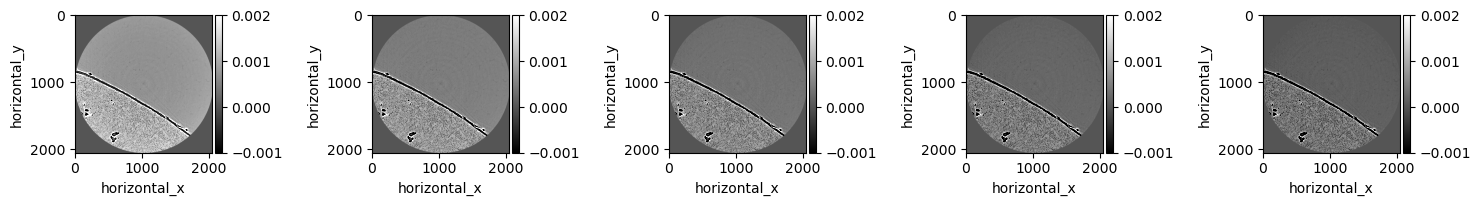

In [112]:
show2D([recon_fbp_512, recon_fbp_1024, recon_fbp_2048, recon_fbp_4096, recon_fbp_8192], cmap=cmap, fix_range = (ca1, ca2), num_cols=5, size=(15,15), origin='upper-left')

In [113]:
import os
from cil.io import TIFFWriter
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1/fbp_slice4/'

# Dictionary mapping numbers to data variables
data_map = {
    512: recon_fbp_512,
    1024: recon_fbp_1024,
    2048: recon_fbp_2048,
    4096: recon_fbp_4096,
    8192: recon_fbp_8192,
}


# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'recon_fbp_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()

# other figures

* compare a slice from elettra recons with the fbp 512 one
* show cupping effect in both slices: the one with almost no sturcture in it and some middle one. 

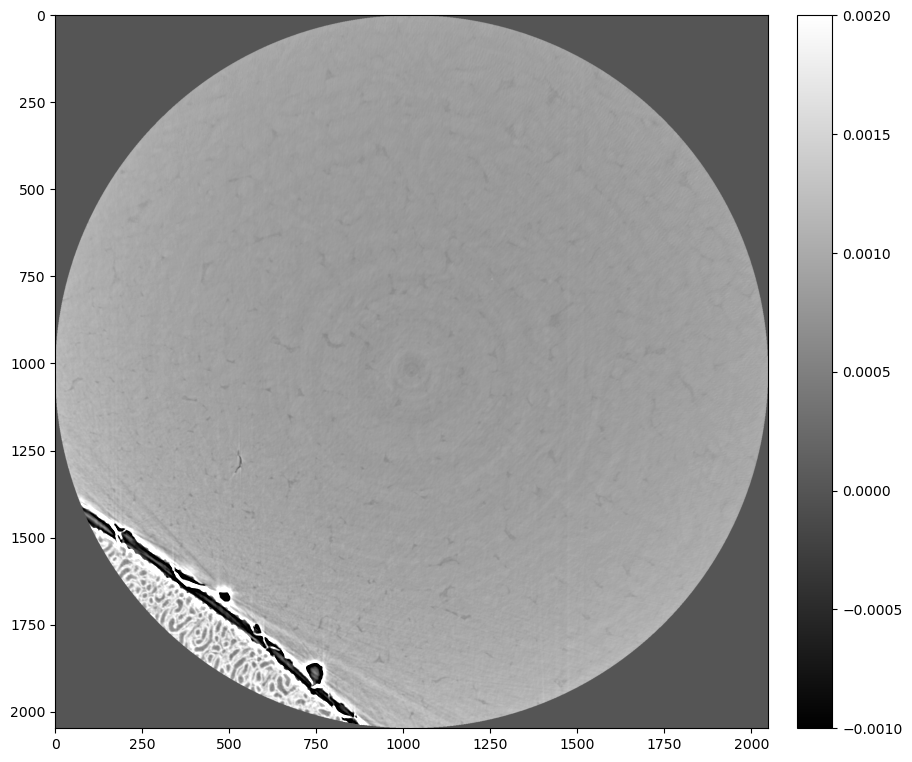

In [6]:
im_dir = "/dtu/cfu/data/userdata15/panum_rats/rat_77/elettra_ct_data/recons/rat_77_full_Z2.35_X2.50_Y4.00/slices/"
im_name = "slice_1023.tif"

# Read the image.
# Here the directory and the image name is concatenated
# by "+" to give the full path to the image.
elettra_X250_Y400 = io.imread(im_dir + im_name)

show2D(elettra_X250_Y400, cmap=cmap, fix_range = (ca1, ca2), num_cols=1, size=(15,15), origin='upper-left')